# 2D FNO Exercise

In [1]:
# %config InlineBackend.figure_format = 'svg'
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat

sys.path.append('../')
from models import FNN1d, FNN_train, construct_model, compute_1dFourier_bases, compute_2dFourier_bases
torch.set_printoptions(precision=16)


# Load data

In [2]:
data_path = "../mytest/data/piececonst_r421_N1024_smooth1"
data = loadmat(data_path)

input date size:  (1024, 421, 421) output data size:  (1024, 421, 421)


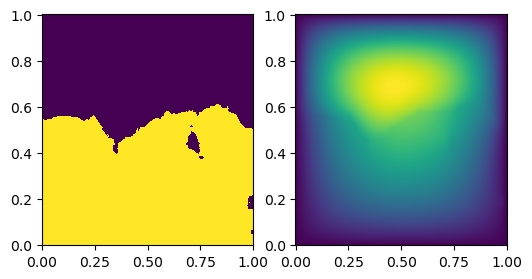

In [3]:
data_in = data["coeff"]
data_out = data["sol"]
print("input date size: ", data_in.shape, "output data size: ", data_out.shape)

L = 1 
Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)

grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].pcolormesh(grid_x, grid_y, data_in[0,:,:])
axs[1].pcolormesh(grid_x, grid_y, data_out[0,:,:])

# 2D Fourier Transform

We compute the Fourier transform for the last 2 dimensions of x. We first define the mode set 

\begin{align*}
K_x = \{k_x | k_x = 0,1,...,n_x/2-1, -n_x/2, -n_x/2+1, ... -1 \} \\
K_y = \{k_y | k_y = 0,1,...,n_y/2-1, -n_y/2, -n_y/2+1, ... -1 \} 
\end{align*}

Then the Fourier transform and inverse Fourier transform give the relation between 
$\{\hat{f}[k_x, k_y]: k_x \in K_x, k_y \in K_y \}$ and $\{f[j_x, j_y] : 0 \leq j_x \leq n_x, 0 \leq j_y \leq n_y\}$

\begin{align*}
   f(x,y) &= \frac{1}{n_x n_y} \sum_{k_x \in K_x, k_y \in K_y}  \hat{f}[k_x, k_y]  e^{i k_x \frac{2\pi x}{L_x} + i k_y \frac{2\pi y}{L_y}} 
   \\ 
   f[j_x, j_y] &= \frac{1}{n_x n_y} \sum_{k_x \in K_x, k_y \in K_y}  \hat{f}[k_x, k_y]  e^{i k_x \frac{2\pi j_x \Delta x}{L_x} + i k_y \frac{2\pi j_y \Delta y}{L_y}} 
   \\ 
   \hat{f}[k_x, k_y] &= \frac{n_x n_y}{L_x L_y} \int f(x, y)  e^{-i k_x \frac{2\pi x}{L_x} - i k_y \frac{2\pi y}{L_y}} dx dy\\
                &\approx \frac{n_x n_y}{L_x L_y}  \sum_{j_x = 0}^{n_x - 1}\sum_{j_y = 0}^{n_y - 1} f[j_x, j_y]  e^{-i k_x \frac{2\pi j_x \Delta x }{L_x} - i k_y \frac{2\pi j_y \Delta y }{L_y}} \Delta x \Delta y \qquad \textrm{when f has certain form, this is accurate.}\\
                &= \sum_{j_x = 0}^{n_x - 1}\sum_{j_y = 0}^{n_y - 1} f[j_x, j_y]  e^{-i k_x \frac{2\pi  j_x}{n_x}-i k_y \frac{2\pi  j_y}{n_y}}
\end{align*}

When $f(x)$ is real, we have $\hat{f}[k_x, k_y] = conj(\hat{f}[-k_x, -k_y])$, and hence `rfftn` only need to save the subset of $K$ 

\begin{align*}
&K_x^r = \{k_x | k_x = 0,1,...,n_x/2-1, -n_x/2, -n_x/2+1, ... -1\} \\
&K_y^r = \{k_y | k_y = 0,1,...,n_y/2-1, -n_y/2\} 
\end{align*}


In FNO, when we truncate to first $k_{xf}$ and $k_{yf}$ modes, we keep
\begin{align*}
& \{(k_x, k_y) | 
k_x = 0,1,...,k_{xf}-1,  -k_{xf}+1, ... -1, 
k_y = 0,1,...,k_{yf}-1\} 
\end{align*}
In the original FNO implementation, $k_x = -k_{xf}$ is also included.

\begin{align*}
f(x,y) 
&= \frac{1}{n_x n_y}  
Re\Bigl(
  \sum_{k_x=-k_{xf}+1}^{k_{xf}-1} \sum_{k_y=0}^{k_{yf}-1} \hat{f}[k_x, k_y]  \phi_{k_x, k_y}(x,y) 
+ \sum_{k_x=-k_{xf}+1}^{k_{xf}-1} \sum_{k_y=-k_{yf}-1}^{-1} \hat{f}[k_x, k_y]  \phi_{k_x, k_y}(x,y) 
\Bigr) 
\\
&= \frac{1}{n_x n_y} Re\Bigl(\sum_{k_x=-k_{xf}+1}^{k_{xf}-1} \hat{f}[k_x, 0]  \phi_{k_x, 0}(x)  +  \sum_{k_x=-k_{xf}+1}^{k_{xf}-1}\sum_{k_y=1}^{k_{yf}-1}  (\hat{f}[k_x, k_y]  \phi_{k_x, k_y}(x,y) + \hat{f}[-k_x, -k_y]  \phi_{-k_x, -k_y}(x,y))\Bigr)
\\
&= \frac{1}{n_x n_y} Re\Bigl(\sum_{k_x=-k_{xf}+1}^{k_{xf}-1} \hat{f}[k_x, 0]  \phi_{k_x, 0}(x)  +  2\sum_{k_x=-k_{xf}+1}^{k_{xf}-1}\sum_{k_y=1}^{k_{yf}-1}  \hat{f}[k_x, k_y]  \phi_{k_x, k_y}(x,y) \Bigr)
\end{align*}



In [4]:
# Here is a test, be careful, the torch will generally use float32. 
# To get accurate error estimate, use float64

downsample_ratio = 45
n_train = 2**10
x_train = torch.from_numpy(np.stack((data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio], 
                           np.tile(grid_x[0::downsample_ratio,0::downsample_ratio], (n_train,1,1)), 
                           np.tile(grid_y[0::downsample_ratio,0::downsample_ratio], (n_train,1,1))), axis=-1))
batchsize = 16
x = x_train[0:batchsize]
# batch, channel, x, y
x = x.permute(0, 3, 1, 2)
x_ft = torch.fft.rfftn(x, dim=[2,3])
print(" The shape of x is ", x.shape, " the shape of x_ft is ", x_ft.shape)

n_b, n_c, n_x, n_y = x.shape
assert(n_x%2 == 0)
n_k = n_y//2

x = x.to(torch.complex128)


# Implementation 1
Kr_x = list(range(0, n_k)) + [-n_k] + list(range(-n_k+1, 0))
Kr_y = list(range(0, n_k)) + [-n_k]
print("len(Kr_x), len(Kr_y) = ", len(Kr_x), len(Kr_y))
x_ft2 = torch.zeros(n_b, n_c, n_x, n_k+1, dtype=torch.complex128)
for j_xk in range(len(Kr_x)):
    for j_yk in range(len(Kr_y)):
        basis = torch.einsum('x,y->xy',
        torch.exp((-Kr_x[j_xk] * 2*np.pi/n_x * 1.0j * torch.linspace(0, n_x-1, n_x, dtype=torch.float64))),
        torch.exp((-Kr_y[j_yk] * 2*np.pi/n_y * 1.0j * torch.linspace(0, n_y-1, n_y, dtype=torch.float64)))
        )
        x_ft2[:, :, j_xk, j_yk] += torch.einsum('bcxy,xy->bc', x, basis)
print("Error between x_ft and x_ft2 is ", torch.norm(x_ft - x_ft2))


# Implementation 2
Kr_x = torch.tensor(list(range(0, n_k)) + [-n_k] + list(range(-n_k+1, 0)), dtype=torch.float64)
Kr_y = torch.tensor(list(range(0, n_k)) + [-n_k], dtype=torch.float64)
bases = torch.einsum('xk,yl->xykl',
                     torch.exp( torch.outer(torch.linspace(0, n_x-1, n_x, dtype=torch.float64), -2*np.pi/n_x * 1.0j * Kr_x) ),
                     torch.exp( torch.outer(torch.linspace(0, n_y-1, n_y, dtype=torch.float64), -2*np.pi/n_y * 1.0j * Kr_y) )  
                    )
x_ft2 = torch.einsum('bcxy,xykl->bckl', x, bases)
print("Error between x_ft and x_ft2 is ", torch.norm(x_ft - x_ft2))

 The shape of x is  torch.Size([16, 3, 10, 10])  the shape of x_ft is  torch.Size([16, 3, 10, 6])
len(Kr_x), len(Kr_y) =  10 6
Error between x_ft and x_ft2 is  tensor(8.3370393483818784e-13, dtype=torch.float64)
Error between x_ft and x_ft2 is  tensor(1.3013251315644093e-12, dtype=torch.float64)


In [5]:
x_ift = torch.fft.irfftn(x_ft, dim=[2,3])
print("Error between x and x_ift is ", torch.norm(x - x_ift))

# For the irfftn, it takes the real part
x_ft_test = torch.clone(x_ft)
print(x_ft_test[0, 0, 2,0], x_ft_test[0,0,-2,0])
x_ft_test[0,0,0,0] += 10.0e10j
x_ft_test[0,0, -2,0] += 10e4j
x_ft_test[0,0,  2,0] += 10e4j
print(x_ft_test.shape)
x_ift = torch.fft.irfftn(x_ft_test, dim=[2,3])
print("Error between x and x_ift is ", torch.norm(x - x_ift))

Error between x and x_ift is  tensor(3.8498401348500772e-14, dtype=torch.float64)
tensor(62.9999999999999716+0.j, dtype=torch.complex128) tensor(62.9999999999999716+0.j, dtype=torch.complex128)
torch.Size([16, 3, 10, 6])
Error between x and x_ift is  tensor(3.6287476804922921e-13, dtype=torch.float64)


In [6]:
x_ift = torch.fft.irfftn(x_ft, dim=[2, 3])
print("Error between x and x_ift is ", torch.norm(x - x_ift))

modes = 6
#  Truncate to the first m modes
x_ft_trunc = torch.zeros(n_b, n_c, n_x, n_k + 1, dtype=torch.complex128)
x_ft_trunc[:, :, :modes, :modes] = x_ft[:, :, :modes, :modes]
x_ft_trunc[:, :, -modes + 1 :, :modes] = x_ft[:, :, -modes + 1 :, :modes]

x_ift_trunc = torch.fft.irfftn(x_ft_trunc, dim=[2, 3])

# Implementation 1
Kr_x = torch.tensor(
    list(range(0, n_k)) + [-n_k] + list(range(-n_k + 1, 0)), dtype=torch.float64
)
Kr_y = torch.tensor(list(range(0, n_k)) + [-n_k], dtype=torch.float64)
bases = torch.einsum(
    "xk,yl->xykl",
    torch.exp(
        torch.outer(
            torch.linspace(0, n_x - 1, n_x, dtype=torch.float64),
            2 * np.pi / n_x * 1.0j * Kr_x,
        )
    ),
    torch.exp(
        torch.outer(
            torch.linspace(0, n_y - 1, n_y, dtype=torch.float64),
            2 * np.pi / n_y * 1.0j * Kr_y,
        )
    ),
)
bases[:, :, :, 1:-1] *= 2.0
x_ift2 = torch.real(torch.einsum("bckl,xykl->bcxy", x_ft_trunc, bases)) / (n_x * n_y)
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))

# Low Rank Implementation
Kr_x = torch.tensor(
    list(range(0, modes)) + list(range(-modes + 1, 0)), dtype=torch.float64
)
Kr_y = torch.tensor(list(range(0, modes)), dtype=torch.float64)
Kr = torch.tensor(list(range(0, modes)), dtype=torch.float64)
bases = torch.einsum(
    "xk,yl->xykl",
    torch.exp(
        torch.outer(
            torch.linspace(0, n_x - 1, n_x, dtype=torch.float64),
            2 * np.pi / n_x * 1.0j * Kr_x,
        )
    ),
    torch.exp(
        torch.outer(
            torch.linspace(0, n_y - 1, n_y, dtype=torch.float64),
            2 * np.pi / n_y * 1.0j * Kr_y,
        )
    ),
)
bases[:, :, :, 1:] *= 2.0
x_ift2 = torch.real(
    torch.einsum(
        "bckl,xykl->bcxy",
        x_ft_trunc[:, :, list(range(0, modes)) + list(range(-modes + 1, 0)), :modes],
        bases,
    )
) / (n_x * n_y)
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))

Error between x and x_ift is  tensor(3.8498401348500772e-14, dtype=torch.float64)
Error between x and x_ift2 is  tensor(1.2472305205542961e-13, dtype=torch.float64)
Error between x and x_ift2 is  tensor(38.5252342428878123, dtype=torch.float64)


# Spectral Transform

We compute the spectral transform for the last dimension of x. 
We first define $n_k$ orthonal bases $\{ \phi_k \}_{k = 0}^{n_k-1}$


Then the spectral transform and inverse spectral transform give the relation between 
$\{\hat{f}[k]: k \in K \}$ and $\{f(x_j) : 0 \leq j \leq n_x\}$

\begin{align*}
   f(x) &= \sum_{k=0}^{n_k-1}  \hat{f}[k]  \phi_k(x) 
   \\ 
   f(x_j) &= \sum_{k_x=0}^{n_k-1}  \hat{f}[k]  \phi_k(x_j)
   \\ 
   \hat{f}[k] &= \int  f(x)  \phi_k(x) dx  \\
                &= \sum_{j = 0}^{n_x}  f(x_j)  \phi_k(x_j) \Delta x_j
\end{align*}
Here $\phi_k(x)$ are orthogonal bases with $$\int \phi_i(x) \overline{\phi_k(x)} dx = \delta_{ik},$$ and at the discrete level
$$\sum_{j = 0}^{n_x} \phi_i(x_j) \overline{\phi_j(x_j)} \Delta x_j = \delta_{ik}$$



We set bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j)  & \phi_1(x_j)  &  \cdots &  \phi_{n_k-1}(x_j)  
\end{bmatrix}
\end{equation}
and weighted bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j) \Delta x_j  & \phi_1(x_j) \Delta x_j &  \cdots &  \phi_{n_k-1}(x_j) \Delta x_j
\end{bmatrix}
\end{equation}

To recover 2D Fourier Transform, we set 
\begin{align*}
\phi_k(x) = \begin{cases}
\frac{a_{k}}{\sqrt{L_xL_y}}\sin(\frac{2\pi k_x x}{L_x} + \frac{2\pi k_y y}{L_y}) & k_y > 0 \cup  k_y=0 \, k_x \geq 0\\ 
\frac{a_{k}}{\sqrt{L_xL_y}}\cos(\frac{2\pi k_x x}{L_x} + \frac{2\pi k_y y}{L_y}) & 
\end{cases}
\end{align*}
with $a_{0,0} = 1$ and $a_{k} = \sqrt{2}$.


In [7]:
torch.manual_seed(0)
np.random.seed(0)

downsample_ratio = 4

L = 1.0
Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)


n_train, n_test = 800, 200
data_in_ds = data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio]
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[0:n_train, 0::downsample_ratio, 0::downsample_ratio]


x_train = torch.from_numpy(
    np.stack(
        (
            data_in_ds,
            np.tile(grid_x_ds, (n_train, 1, 1)),
            np.tile(grid_y_ds, (n_train, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_train = torch.from_numpy(data_out_ds[:, :, :, np.newaxis].astype(np.float32))
x_test = torch.from_numpy(
    np.stack(
        (
            data_in[-n_test:, 0::downsample_ratio, 0::downsample_ratio],
            np.tile(grid_x[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
            np.tile(grid_y[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_test = torch.from_numpy(
    data_out[-n_test:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis].astype(
        np.float32
    )
)


x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])


torch.Size([800, 11236, 3])
torch.Size([800, 11236, 1])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
106.0


In [8]:
k_max = 33
model_type = "GalerkinNO"
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
gridx, gridy, fbases, weights = compute_2dFourier_bases(Np, Np, k_max, L, L)
fbases = fbases.reshape(-1, k_max)
weights = weights.reshape(-1)
wfbases = fbases * np.tile(weights, (k_max, 1)).T
bases_fourier = torch.from_numpy(fbases.astype(np.float32))
wbases_fourier = torch.from_numpy(wfbases.astype(np.float32))

pca_data = data_out_ds.reshape((data_out_ds.shape[0], -1))
pca_include_input = False
pca_include_grid = False
if pca_include_input:
    pca_data = np.vstack(
        (pca_data, data_in_ds.reshape((data_in_ds.shape[0], -1)))
    )
if pca_include_grid:
    n_grid = 1
    pca_data = np.vstack((pca_data, np.tile(grid_x_ds, (n_grid, 1))))
    pca_data = np.vstack((pca_data, np.tile(grid_y_ds, (n_grid, 1))))
print("Start SVD with data shape: ", pca_data.shape)
U, S, VT = np.linalg.svd(pca_data.T, full_matrices=False)
fbases = U[:, 0:k_max] / np.sqrt(L * L / Np**2)
wfbases = L * L / Np**2 * fbases
bases_pca = torch.from_numpy(fbases.astype(np.float32))
wbases_pca = torch.from_numpy(wfbases.astype(np.float32))

Start SVD with data shape:  (800, 11236)


In [9]:
galerkin_config_std1 = {
    "type": "GalerkinConv",
    "num_modes": k_max,
    "bases": bases_fourier,
    "wbases": wbases_fourier,
}
galerkin_config_std2 = {
    "type": "GalerkinConv",
    "num_modes": k_max,
    "bases": bases_pca,
    "wbases": wbases_pca,
}
fourier_config_std = {
    "type": "FourierConv2d",
    "num_modes1": k_max // 2,
    "num_modes2": k_max // 2,
}
attention_config_std = {
    "type": "Attention",
    "num_heads": 1,
    "attention_type": "galerkin",
}
layer_configs = [fourier_config_std, galerkin_config_std1, fourier_config_std]


config = {
    "model": {
        "model": "GalerkinNO",
        "dim": 1,
        "fc_dim": 128,
        "layers": [64] * 4,
        "in_dim": 3,
        "out_dim": 1,
        "act": "gelu",
        "pad_ratio": -1,
        "layer_configs": layer_configs,
    },
    "train": {
        "base_lr": 0.001,
        "weight_decay": 1.0e-4,
        "epochs": 1000,
        "scheduler": "MultiStepLR",
        "milestones": [200, 300, 400, 500, 800, 900],
        "scheduler_gamma": 0.5,
        "batch_size": 8,
        "normalization_x": True,
        "normalization_y": True,
        "normalization_dim": [],
    },
}


model = construct_model(config)
print(model)

GkNN(
  (fc0): Linear(in_features=3, out_features=64, bias=True)
  (sp_layers): ModuleList(
    (0): SpectralConv2d_test()
    (1): GalerkinConv()
    (2): SpectralConv2d_test()
  )
  (ws): ModuleList(
    (0-2): 3 x Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [10]:
print("Start training ", config["model"]["model"])
print("x_train shape: ", x_train.shape, "y_train shape: ", y_train.shape)
print("x_test shape: ", x_train.shape, "y_test shape: ", y_train.shape)

train_rel_l2_losses, test_rel_l2_losses, test_l2_losses = FNN_train(
    x_train, y_train, x_test, y_test, config, model, save_model_name="models/test"
)

Start training  GalerkinNO
x_train shape:  torch.Size([800, 11236, 3]) y_train shape:  torch.Size([800, 11236, 1])
x_test shape:  torch.Size([800, 11236, 3]) y_test shape:  torch.Size([800, 11236, 1])


KeyboardInterrupt: 